In [15]:
# %% Import Libraries
# Basic libraries
import os                               # directories
import scipy.io                         # load mat files
import numpy as np                      
import pandas as pd
import pickle
import torch as tc
import matplotlib.pyplot as plt

import matplotlib.patches as mpatches
from tqdm import tqdm
from bptt.models import Model
import model_anafunctions as func

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import zscore
import model_anafunctions as func      # Loading personalized functions

import ruptures as rpt                 # Package for change points

plt.rcParams['font.size'] = 20         # Parameter modified in all the plots of the notebook

In [16]:
#%% FUNCTIONS
def Hyper_mod(mpath,data_path):
    file=open(os.path.join(mpath,'hypers.pkl').replace("\\","/"),'rb')
    hyper=pickle.load(file)
    file.close()
    hyper['data_path']=os.path.join(data_path,'Training_data.npy').replace('\\','/')
    hyper['inputs_path']=os.path.join(data_path,'Training_inputs.npy').replace('\\','/')
    print(hyper['device_id'])
    hyper['device_id'] = 0
    print(hyper['device_id'])    
    full_name = open(os.path.join(mpath,'hypers.pkl').replace("\\","/"),"wb")                      # Name for training data
    pickle.dump(hyper,full_name)            # Save train data
    #close save instance 
    full_name.close()

0
0
Chosen model is clipped shPLRNN, the bases Parameter has no effect here!


100%|██████████| 55/55 [00:06<00:00,  9.04it/s]


Text(0.5, 1.0, 'Session for modelling')

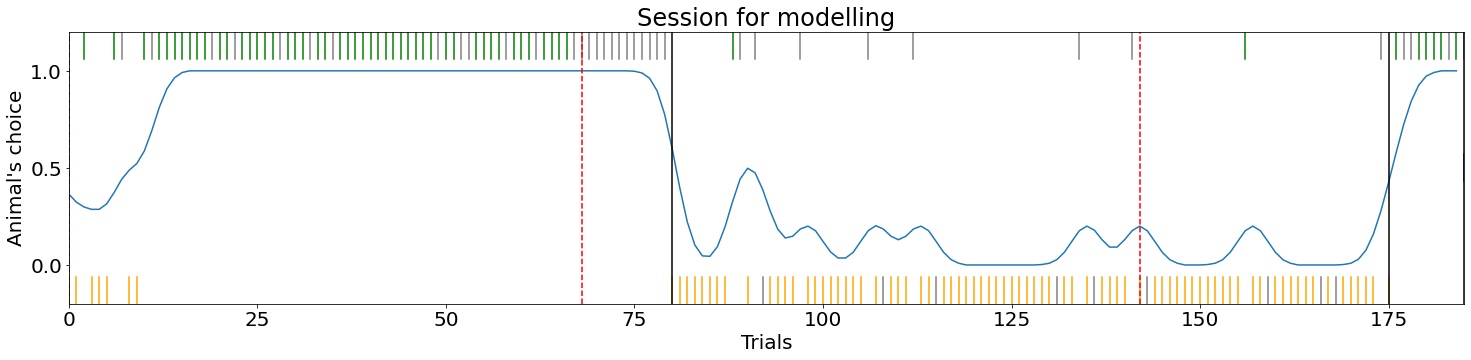

In [73]:
#%% Load Data and Behaviour
################################ Directories and files to modify ################################ 
# Select Path for multi-unit data
data_path = 'D:\\_work_cestarellas\\Analysis\\Pack_Daniel_project\\Preprocess_model\\bptt_CE17\\neuralactivity\\datasets\\' 
#data_path = 'D:/_work_cestarellas/Analysis/PLRNN/noautoencoder/neuralactivity/OFC/CE17/L6/Test0/datasets/' 
# Select Path for Models (Folder containing the specific models to test)
model_path = 'D:\\_work_cestarellas\Analysis\\Pack_Daniel_project\\Preprocess_model\\bptt_CE17\\results'
#model_path = 'D:/_work_cestarellas/Analysis/PLRNN/noautoencoder/results/Tuning_OFC_CE17_221008'
#meta information
Meta_file_path = "D:\\_work_cestarellas\\Analysis\\Pack_Daniel_project\\Preprocess_model\\bptt_CE17\\neuralactivity\\datasets\\Metadata.pkl"
#Behaviour path
path_beh='D:/_work_cestarellas/Analysis/PLRNN/Session_Selected/OFC/CE17_L6'

# Loading models and simulations
model_name = 'DataTrainingH768_lm1_1e-05_lm2_128_lm3_00_seql_400/001'
#model_name = 'CE1701_HU_256_l1_0.001_l2_08_l3_00_SL_400_encdim_65/001'

## Loading recorded neuronal activity (pre-processesed)
mpath=os.path.join(model_path,model_name).replace('\\','/')

train_n,train_i = func.load_data(data_path,'Training')
test_n,test_i = func.load_data(data_path,'Test')
# Loading Metadata info
file=open(os.path.join(data_path,'Metadata.pkl'),'rb')
Metadata_info=pickle.load(file)
file.close()

Hyper_mod(mpath,data_path)

# Loading Model
num_epochs = 150000
m = Model()
m.init_from_model_path(mpath, epoch=num_epochs)
m.eval()

# Generation Training Data
ModelS=[]
for w_index in tqdm(range(len(train_n))):
    data_trial=tc.from_numpy(train_n[w_index]).float()          # tensor of neuronal data for initial trial data
    input_trial = tc.from_numpy(train_i[w_index]).float()
    length_sim = input_trial.shape[0]
    X, _ = m.generate_free_trajectory(data_trial,input_trial,length_sim,w_index)
    ModelS.append(X[:,:])

# Concatenating signals
Nseries,_=func.concatenate_list(train_n,0)          # recorded activity
Iseries,_=func.concatenate_list(train_i,0)          # external input
Mseries,_=func.concatenate_list(ModelS,0)           # simulated activity

train_trials = [(np.where(np.diff(train_i[i][:,0])==1)[0]-49).shape[0] for i in range(len(train_i))]
test_trials = [(np.where(np.diff(test_i[i][:,0])==1)[0]-49).shape[0] for i in range(len(test_i))]

Number_trials = len(Metadata_info["TrainingTrials"])+len(Metadata_info["TestTrials"])
Vec = np.full((Number_trials,1),np.nan)
Vec[Metadata_info["TrainingTrials"],0] = train_trials
Vec[Metadata_info["TestTrials"],0] = test_trials

CSum_vec = np.cumsum(Vec)                                   # Cumulative sum trials for the behaviour
CSum_train = np.cumsum(np.array(train_trials))              # Cumulative sum trials for training trials


ll=0

os.chdir(path_beh)
list_files = os.listdir(path_beh)

for i in list_files:
    if i.find('Behaviour')>0:
        Behaviour_name = i

# Load data
# Open the Behaviour file
Bdata = scipy.io.loadmat(Behaviour_name)
BehData = Bdata[list(Bdata.keys())[-1]]
# Classification of trials following the behabiour
GambleRewardTrials = np.where((BehData[:,12]==1) & (BehData[:,13]==1))[0]
GambleNoRewardTrials =  np.where((BehData[:,12]==1) & (BehData[:,13]==0))[0]
SafeRewardTrials = np.where((BehData[:,12]==0) & (BehData[:,13]==1))[0]
SafeNoRewardTrials = np.where((BehData[:,12]==0) & (BehData[:,13]==0))[0]
NoRespondingTrials = np.where(BehData[:,10]==1)[0]

# Blocks
Block_Prob = np.unique(BehData[:,5])
BlockTrials = [np.where(Block_Prob[i]==BehData[:,5])[0][0] for i in range(len(Block_Prob))]
# Smoothing the data for plotting
ScaleDecision=BehData[:,12]+(BehData[:,12]-1)
SigmaDecision=1
Binx =0.5
KernelWindow = np.arange(-3*SigmaDecision, 3*SigmaDecision, Binx)
KernelDecision = np.exp(-(KernelWindow/SigmaDecision)**2/2)
DecisionConvolution=np.convolve(ScaleDecision,KernelDecision,mode='same')
DecisionNormalized=(DecisionConvolution/np.nanmax(np.abs(DecisionConvolution))+1)/2

if NoRespondingTrials[0]<20:
    first_trial = NoRespondingTrials[0]+1
    last_trial = NoRespondingTrials[1]-1
else:
    first_trial = 0
    last_trial = NoRespondingTrials[ll]-1

last_trial = int(CSum_vec[-1])
if np.isnan(DecisionNormalized).any():
    # Find indices of valid values and their corresponding values
    valid_indices = np.where(~np.isnan(DecisionNormalized))[0]
    valid_values = DecisionNormalized[valid_indices]

    # Generate indices to interpolate (including NaNs)
    interpolate_indices = np.arange(len(DecisionNormalized))

    # Interpolate NaN values
    interpolated_values = np.interp(interpolate_indices, valid_indices, valid_values)
    BD = interpolated_values[0:last_trial]
else:
    BD=DecisionNormalized[0:last_trial]

# Behaviour
# Perform change point detection
algo = rpt.Window(model="l2",width=10).fit(BD)
result_beh = algo.predict(n_bkps=2)


# FIGURE: Plot behaviour performance
plt.figure(figsize=(25,5))
plt.plot(BD)
for i in GambleRewardTrials:
    plt.axvline(i,ymin=0.9,ymax=1.0,color='g') 
for i in GambleNoRewardTrials:
    plt.axvline(i,ymin=0.9,ymax=1.0,color='gray')
for i in SafeRewardTrials:
    plt.axvline(i,ymin=0.0,ymax=0.1,color='orange')
for i in SafeNoRewardTrials:
    plt.axvline(i,ymin=0.0,ymax=0.1,color='gray')
for i in NoRespondingTrials:
    plt.axvline(i,ymin=0.45,ymax=0.55,color='blue')
for i in BlockTrials:
    plt.axvline(i,linestyle='dashed',color='r',)    
for i in result_beh:
    plt.axvline(i,color='k')
plt.ylim([-0.2,1.2])
plt.yticks(ticks=[1.0,0.5,0.0])
plt.xlim([first_trial,last_trial])
plt.xlabel('Trials')
plt.ylabel("Animal's choice")
plt.title('Session for modelling')

In [74]:
# Preparing data for change points detection version 1:

# Temporal sectors: Period of time selected to compute the mean firing rate
TrialTime_ini = np.where(np.diff(Iseries[:,0])==1)[0]-49                         # Initial point: Beginning trial
TrialTime_end = np.append(TrialTime_ini[1:],Iseries.shape[0])                    # Final point: Ending trial
# Determining number of trials and number of neurons
num_trials = len(TrialTime_end)
num_neurons = Nseries.shape[1]
X_data = np.zeros((num_trials,num_neurons))                                     # Initial matrix of mean firing rate of each neuron (columns), and trials (rows)
X_model = np.zeros((num_trials,num_neurons))                                     # Initial matrix of mean firing rate of each neuron (columns), and trials (rows)
for it in range(num_trials):
    X_data[it,:]=np.mean(Nseries[TrialTime_ini[it]:TrialTime_end[it],:],0)
    X_model[it,:]=np.mean(Mseries[TrialTime_ini[it]:TrialTime_end[it],:],0)


MUA_data = X_data.mean(1)                                                            # Mean value of the firing rate
MUA_model = X_model.mean(1)


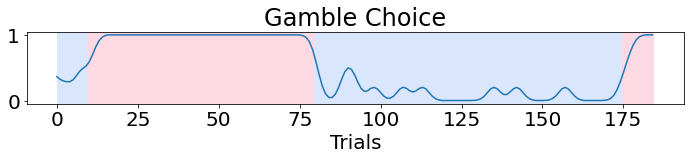

In [75]:
######################  CHANGE POINT ######################

# Computing change points from behaviour performance: Gamble Choice probability (BD)
model_ch = rpt.Pelt(model="rbf",min_size=5)
model_ch.fit(BD)
result_ch = model_ch.predict(pen=5)

# display Behavioural and Signal change points
rpt.display(BD,result_ch)
plt.title("Gamble Choice")
plt.xlabel("Trials")
plt.show()


(0.0, 11.0)

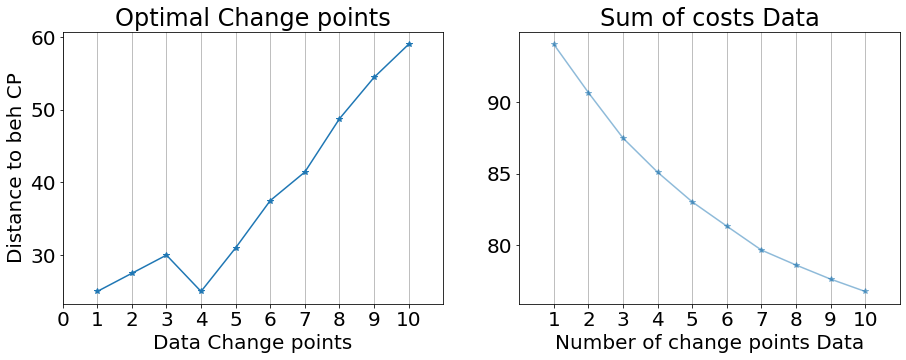

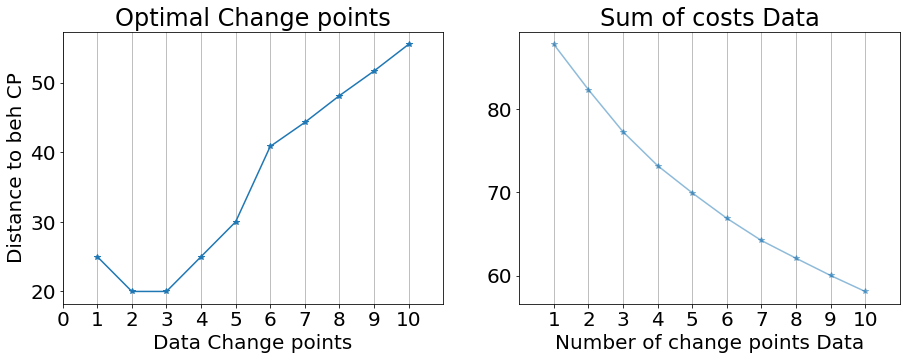

In [76]:
## PARAMETERS TO CHANGE:
min_size_cp = 10                                                                                        # minimum number of samples between two change points
penalty = 5                                                                                             # Value to indicate the influence of the number of behavioural change points
n_bkps_max = 10                                                                                         # Choose the number of changes (elbow heuristic)

#######################################################################################################
######## Computing optimal number of change points through the cost function (elbow mehtod) ###########
#######################################################################################################
algo = rpt.Dynp(model="rbf",min_size=min_size_cp)                                                       # Generating model
algo.fit(X_data)                                                                                        # Fitting Data

# Start by computing the segmentation with most changes.
# After start, all segmentations with 1, 2,..., K_max-1 changes are also available for free.
pre=algo.predict(n_bkps_max)
array_of_n_bkps = np.arange(1, n_bkps_max + 1)

#Function to return the sum of costs for a specific number of change points (used in Figure section)
def get_sum_of_cost(algo, n_bkps) -> float:
    """Return the sum of costs for the change points `bkps`"""
    bkps = algo.predict(n_bkps=n_bkps)
    return algo.cost.sum_of_costs(bkps)

######################################################################################################
##### Computing optimal number of change points depending on behavioural change point distance #######
######################################################################################################
algo_b = rpt.Dynp(model="rbf", min_size=min_size_cp)                                                    # Generating model
algo_b.fit(X_data)                                                                                      # Fitting Data

# Initialization of variables
cp_data = []                                                                                            # Variable for neuronal change points
cp_behaviour = []                                                                                       # Variable for behavioural change points
distance = []                                                                                           # Variable for trial distance between neuronal and behavioural change points
cp_id =[]                                                                                               # # Variable for the number identification of the neuronal change point determined
                                                                                              
# Loop testing different number of change points
for bk in array_of_n_bkps:
    result_mua_sup = algo_b.predict(n_bkps=bk)
    cps_mua = result_mua_sup[:-1]
    cps_beh = result_ch[:-1]
    dist_mua= []
    for bkp in cps_mua:
        dist_cp = [np.abs(bkp-i) for i in cps_beh]
        dist_mua.append(np.array(dist_cp))

    for i in range(len(cps_mua)):
        trial_distance = dist_mua[i].min()+penalty*(np.abs(len(cps_mua)-len(cps_beh)))
        cp_pos = np.argmin(dist_mua[i])
        cp_data.append(cps_mua[i])
        cp_behaviour.append(cps_beh[cp_pos])
        distance.append(trial_distance)
        cp_id.append(bk)

# Generating DataFrame with change points information
CP_info = {"CP_data":cp_data,
        "CP_behaviour":cp_behaviour,
        "Trial_distance":distance,
        "CP_id":cp_id}
CP_df = pd.DataFrame(CP_info)                                                                           # Dataframe

# Grouping values per neuronal change point
CP_opt = CP_df.groupby("CP_id").mean()

######################################################################################################
################## FIGURE: optimal number of change points for both methods ##########################
######################################################################################################
plt.figure(figsize=(15,5))
# Subplot 1: Showing plot of optimal number of neuronal change points 
# taking into acount the number of behavioural change points
plt.subplot(1,2,1)
plt.plot(CP_opt.index,CP_opt["Trial_distance"],'-*')
plt.grid(axis="x")
plt.xlim(1, n_bkps_max + 1)
plt.xticks(range(n_bkps_max + 1))
plt.xlabel("Data Change points")
plt.ylabel("Distance to beh CP")
plt.title("Optimal Change points")
# Subplot 2: Computing and showing the computational cost
plt.subplot(1,2,2)
plt.plot(
    array_of_n_bkps,
    [get_sum_of_cost(algo=algo, n_bkps=n_bkps) for n_bkps in array_of_n_bkps],
    "-*",
    alpha=0.5,
)
plt.xticks(array_of_n_bkps)
plt.xlabel("Number of change points Data")
plt.title("Sum of costs Data")
plt.grid(axis="x")
plt.xlim(0, n_bkps_max + 1)


###########################################################################################################################################
## PARAMETERS TO CHANGE:
min_size_cp = 10                                                                                        # minimum number of samples between two change points
penalty = 5                                                                                             # Value to indicate the influence of the number of behavioural change points
n_bkps_max = 10                                                                                         # Choose the number of changes (elbow heuristic)

#######################################################################################################
######## Computing optimal number of change points through the cost function (elbow mehtod) ###########
#######################################################################################################
algo = rpt.Dynp(model="rbf",min_size=min_size_cp)                                                       # Generating model
algo.fit(X_model)                                                                                        # Fitting Data

# Start by computing the segmentation with most changes.
# After start, all segmentations with 1, 2,..., K_max-1 changes are also available for free.
pre=algo.predict(n_bkps_max)
array_of_n_bkps = np.arange(1, n_bkps_max + 1)

#Function to return the sum of costs for a specific number of change points (used in Figure section)
def get_sum_of_cost(algo, n_bkps) -> float:
    """Return the sum of costs for the change points `bkps`"""
    bkps = algo.predict(n_bkps=n_bkps)
    return algo.cost.sum_of_costs(bkps)

######################################################################################################
##### Computing optimal number of change points depending on behavioural change point distance #######
######################################################################################################
algo_b = rpt.Dynp(model="rbf", min_size=min_size_cp)                                                    # Generating model
algo_b.fit(X_model)                                                                                      # Fitting Data

# Initialization of variables
cp_data = []                                                                                            # Variable for neuronal change points
cp_behaviour = []                                                                                       # Variable for behavioural change points
distance = []                                                                                           # Variable for trial distance between neuronal and behavioural change points
cp_id =[]                                                                                               # # Variable for the number identification of the neuronal change point determined
                                                                                              
# Loop testing different number of change points
for bk in array_of_n_bkps:
    result_mua_sup = algo_b.predict(n_bkps=bk)
    cps_mua = result_mua_sup[:-1]
    cps_beh = result_ch[:-1]
    dist_mua= []
    for bkp in cps_mua:
        dist_cp = [np.abs(bkp-i) for i in cps_beh]
        dist_mua.append(np.array(dist_cp))

    for i in range(len(cps_mua)):
        trial_distance = dist_mua[i].min()+penalty*(np.abs(len(cps_mua)-len(cps_beh)))
        cp_pos = np.argmin(dist_mua[i])
        cp_data.append(cps_mua[i])
        cp_behaviour.append(cps_beh[cp_pos])
        distance.append(trial_distance)
        cp_id.append(bk)

# Generating DataFrame with change points information
CP_info = {"CP_data":cp_data,
        "CP_behaviour":cp_behaviour,
        "Trial_distance":distance,
        "CP_id":cp_id}
CP_df = pd.DataFrame(CP_info)                                                                           # Dataframe

# Grouping values per neuronal change point
CP_opt = CP_df.groupby("CP_id").mean()

######################################################################################################
################## FIGURE: optimal number of change points for both methods ##########################
######################################################################################################
plt.figure(figsize=(15,5))
# Subplot 1: Showing plot of optimal number of neuronal change points 
# taking into acount the number of behavioural change points
plt.subplot(1,2,1)
plt.plot(CP_opt.index,CP_opt["Trial_distance"],'-*')
plt.grid(axis="x")
plt.xlim(1, n_bkps_max + 1)
plt.xticks(range(n_bkps_max + 1))
plt.xlabel("Data Change points")
plt.ylabel("Distance to beh CP")
plt.title("Optimal Change points")
# Subplot 2: Computing and showing the computational cost
plt.subplot(1,2,2)
plt.plot(
    array_of_n_bkps,
    [get_sum_of_cost(algo=algo, n_bkps=n_bkps) for n_bkps in array_of_n_bkps],
    "-*",
    alpha=0.5,
)
plt.xticks(array_of_n_bkps)
plt.xlabel("Number of change points Data")
plt.title("Sum of costs Data")
plt.grid(axis="x")
plt.xlim(0, n_bkps_max + 1)

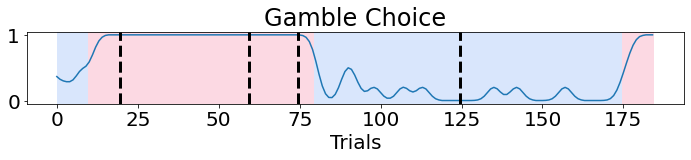

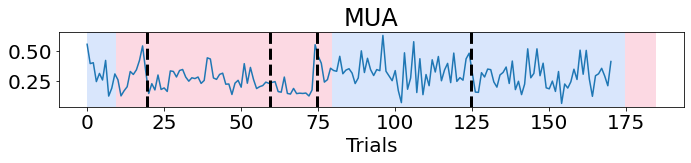

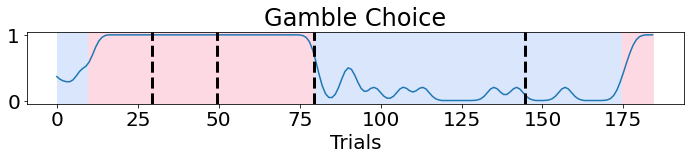

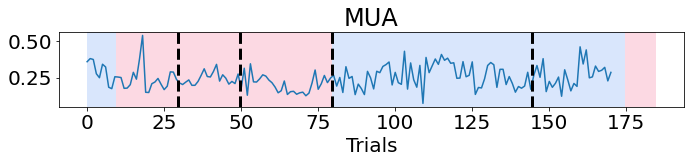

In [77]:
# Decide the optimal change point
opt_bk = 4

algo_ex = rpt.Dynp(model="rbf", min_size=min_size_cp)                                                    # Generating model
algo_ex.fit(X_data) 

result_mua = algo_ex.predict(n_bkps=opt_bk)

# Plot of change points for behavioural performance
rpt.display(BD,result_ch,result_mua[:-1])
plt.title("Gamble Choice")
plt.xlabel("Trials")
plt.show()
# Plot of change points for MUA
rpt.display(MUA_data,result_ch,result_mua[:-1])
plt.title("MUA")
plt.xlabel("Trials")
plt.show()



#########################################################################
# Decide the optimal change point
opt_bk = 4

algo_ex = rpt.Dynp(model="rbf", min_size=min_size_cp)                                                    # Generating model
algo_ex.fit(X_model) 

result_mua_model = algo_ex.predict(n_bkps=opt_bk)

# Plot of change points for behavioural performance
rpt.display(BD,result_ch,result_mua_model[:-1])
plt.title("Gamble Choice")
plt.xlabel("Trials")
plt.show()
# Plot of change points for MUA
rpt.display(MUA_model,result_ch,result_mua_model[:-1])
plt.title("MUA")
plt.xlabel("Trials")
plt.show()

In [78]:
cps_mua = result_mua[:-1]
cps_mua_model = result_mua_model[:-1]
# Tranformation of trials to correct concatenate trials
cp_data = []
cp_model = []
cp_behaviour = []

for i in range(len(cps_mua)):
    cp_data.append(cps_mua[i])

for i in range(len(cps_mua_model)):
    cp_model.append(cps_mua_model[i])

for i in range(len(cps_beh)):
    cp_behaviour.append(cps_beh[i])

cp_data_trans = [Metadata_info["TrainingTrials"][np.where(np.array(CSum_train)<i)[0].shape[0]-1] for i in cp_data]
cp_beha_trans = [np.where(np.array(CSum_vec)<i)[0].shape[0] for i in cp_behaviour]
cp_mode_trans = [Metadata_info["TrainingTrials"][np.where(np.array(CSum_train)<i)[0].shape[0]-1] for i in cp_model]

print("Neuronal cp: ", cp_data_trans)
print("Model cp: ", cp_mode_trans)
print("Behavioural cp: ", cp_beha_trans)

Neuronal cp:  [6, 21, 26, 42]
Model cp:  [10, 17, 28, 48]
Behavioural cp:  [3, 27, 55]


Computing Correlation W1
Computing Correlation W2


Text(105.0, 0.5, 'Trials')

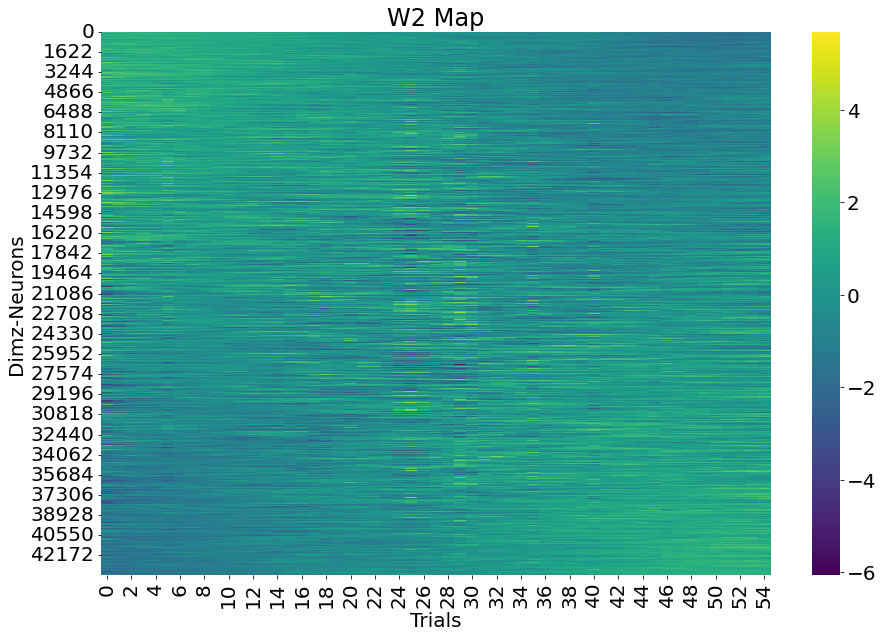

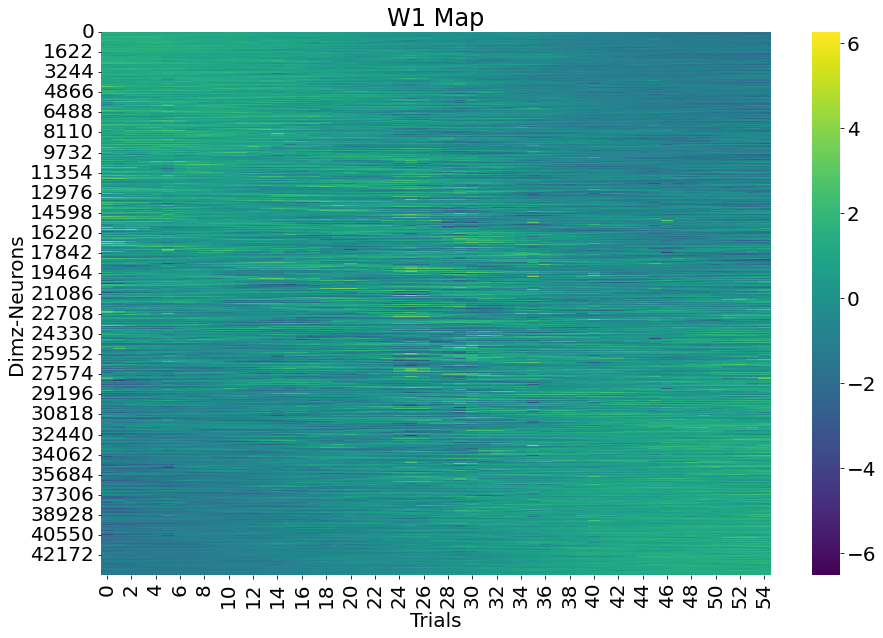

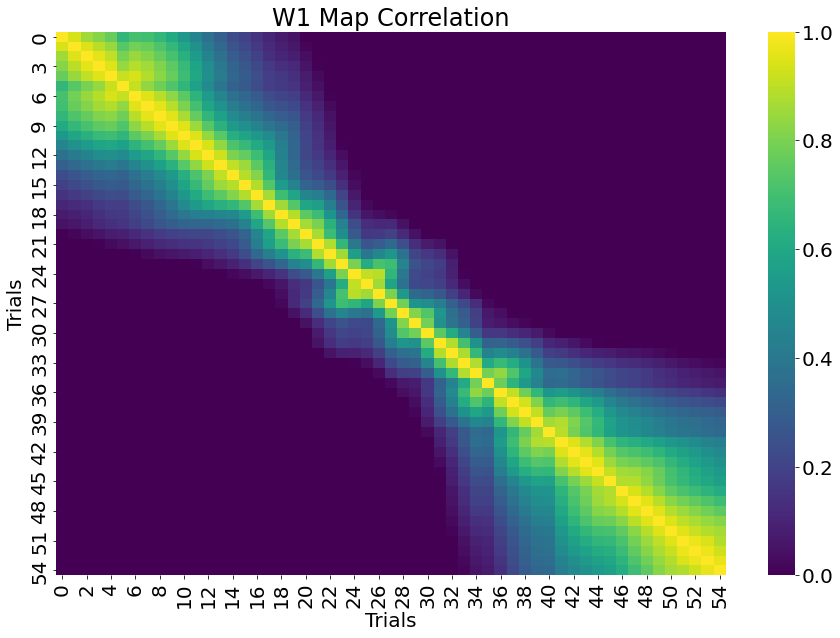

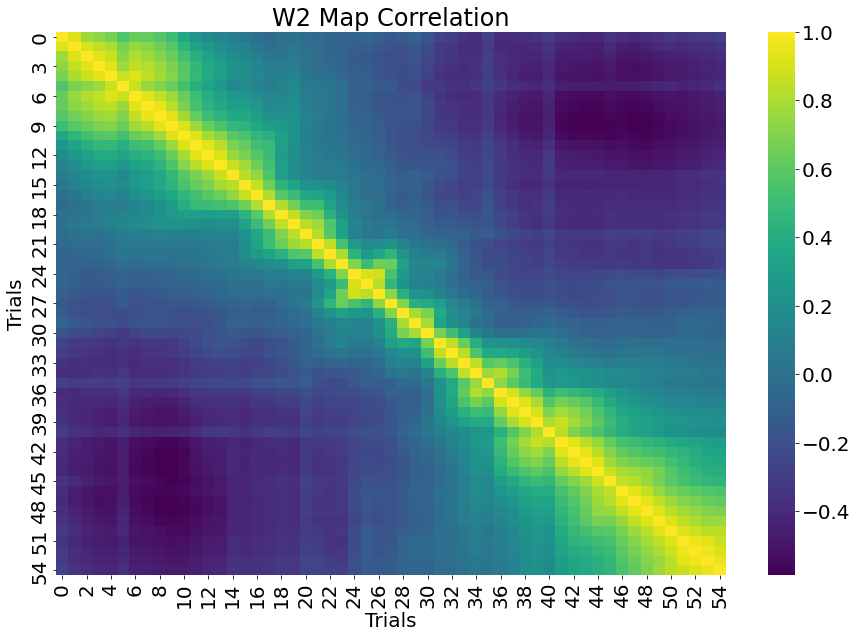

In [81]:
######################### W parameters ###############################################
At, W1t, W2t, h1t, h2t, Ct = m.get_latent_parameters()
# Transform tensor to numpy format
A = At.detach().numpy()
W2 = W2t.detach().numpy().transpose(1,2,0)
W1 = W1t.detach().numpy().transpose(1,2,0)
h1 = h1t.detach().numpy()
h2 = h2t.detach().numpy()
C = Ct.detach().numpy()

# Parameters
HU=W2.shape[1]                      # Number hidden units
Neurons=W2.shape[0]                 # Number Neurons
Trials=W2.shape[2]                  # Number Trials

# W2 Matrix
W2_np = W2
mat=W2_np
mat=mat.reshape(-1,mat.shape[2])
mat=zscore(mat,axis=1)
sort_pos = func.sort_by_slope(mat)
mat=mat[sort_pos,:]

plt.figure(figsize=(15,10))
plt.rcParams['font.size'] = 20
sns.heatmap(data=mat,cmap='viridis')
plt.axvline(280,color='k')
plt.title('W2 Map')
plt.xlabel('Trials')
plt.ylabel('Dimz-Neurons')

# W1 Matrix
W1_np = W1
mat1=W1_np
mat1=mat1.reshape(-1,mat1.shape[2])
mat1=zscore(mat1,axis=1)
sort_pos = func.sort_by_slope(mat1)
mat1=mat1[sort_pos,:]

plt.figure(figsize=(15,10))
plt.rcParams['font.size'] = 20
sns.heatmap(data=mat1,cmap='viridis')
plt.axvline(280,color='k')
plt.title('W1 Map')
plt.xlabel('Trials')
plt.ylabel('Dimz-Neurons')

#Correlation W1 and W2 matrix trialbytrial
print('Computing Correlation W1')
W1_cortbt=np.corrcoef(mat1.T)
print('Computing Correlation W2')
W2_cortbt=np.corrcoef(mat.T)

plt.figure(figsize=(15,10))
plt.rcParams['font.size'] = 20
sns.heatmap(data=W1_cortbt,cmap='viridis',vmin=0,vmax=1)
plt.title('W1 Map Correlation')
plt.xlabel('Trials')
plt.ylabel('Trials')

#Correlation W2 matrix trialbytrial
plt.figure(figsize=(15,10))
plt.rcParams['font.size'] = 20
sns.heatmap(data=W2_cortbt,cmap='viridis')
plt.title('W2 Map Correlation')
plt.xlabel('Trials')
plt.ylabel('Trials')

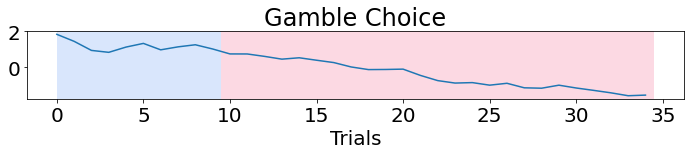

In [71]:
######################  CHANGE POINT ######################
W_params = mat.T
# Computing change points from behaviour performance: Gamble Choice probability (BD)
model_ch = rpt.Pelt(model="rbf",min_size=5)
model_ch.fit(W_params)
result_w = model_ch.predict(pen=3)

# display Behavioural and Signal change points
rpt.display(W_params[:,0],result_w)
plt.title("Gamble Choice")
plt.xlabel("Trials")
plt.show()

cp_w = [Metadata_info["TrainingTrials"][result_w[i]] for i in range(len(result_w)-1)]

In [72]:
print("Neuronal cp: ", cp_data_trans)
print("Model cp: ", cp_mode_trans)
print("Behavioural cp: ", cp_beha_trans)
print("W parameters cp: ", cp_w)

Neuronal cp:  [3, 7, 22, 28]
Model cp:  [3, 7, 22, 28]
Behavioural cp:  [7, 26, 32]
W parameters cp:  [11]


(0.0, 4.0)

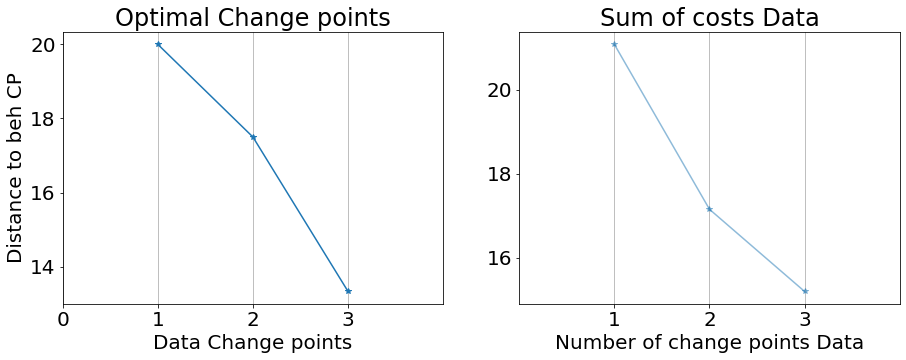

In [62]:


###########################################################################################################################################
## PARAMETERS TO CHANGE:
min_size_cp = 10                                                                                        # minimum number of samples between two change points
penalty = 5                                                                                             # Value to indicate the influence of the number of behavioural change points
n_bkps_max = 3                                                                                         # Choose the number of changes (elbow heuristic)

#######################################################################################################
######## Computing optimal number of change points through the cost function (elbow mehtod) ###########
#######################################################################################################
algo = rpt.Dynp(model="rbf",min_size=min_size_cp)                                                       # Generating model
algo.fit(W_params)                                                                                        # Fitting Data

# Start by computing the segmentation with most changes.
# After start, all segmentations with 1, 2,..., K_max-1 changes are also available for free.
pre=algo.predict(n_bkps_max)
array_of_n_bkps = np.arange(1, n_bkps_max + 1)

#Function to return the sum of costs for a specific number of change points (used in Figure section)
def get_sum_of_cost(algo, n_bkps) -> float:
    """Return the sum of costs for the change points `bkps`"""
    bkps = algo.predict(n_bkps=n_bkps)
    return algo.cost.sum_of_costs(bkps)

######################################################################################################
##### Computing optimal number of change points depending on behavioural change point distance #######
######################################################################################################
algo_b = rpt.Dynp(model="rbf", min_size=min_size_cp)                                                    # Generating model
algo_b.fit(W_params)                                                                                      # Fitting Data

# Initialization of variables
cp_data = []                                                                                            # Variable for neuronal change points
cp_behaviour = []                                                                                       # Variable for behavioural change points
distance = []                                                                                           # Variable for trial distance between neuronal and behavioural change points
cp_id =[]                                                                                               # # Variable for the number identification of the neuronal change point determined
                                                                                              
# Loop testing different number of change points
for bk in array_of_n_bkps:
    result_mua_sup = algo_b.predict(n_bkps=bk)
    cps_mua = result_mua_sup[:-1]
    cps_beh = result_ch[:-1]
    dist_mua= []
    for bkp in cps_mua:
        dist_cp = [np.abs(bkp-i) for i in cps_beh]
        dist_mua.append(np.array(dist_cp))

    for i in range(len(cps_mua)):
        trial_distance = dist_mua[i].min()+penalty*(np.abs(len(cps_mua)-len(cps_beh)))
        cp_pos = np.argmin(dist_mua[i])
        cp_data.append(cps_mua[i])
        cp_behaviour.append(cps_beh[cp_pos])
        distance.append(trial_distance)
        cp_id.append(bk)

# Generating DataFrame with change points information
CP_info = {"CP_data":cp_data,
        "CP_behaviour":cp_behaviour,
        "Trial_distance":distance,
        "CP_id":cp_id}
CP_df = pd.DataFrame(CP_info)                                                                           # Dataframe

# Grouping values per neuronal change point
CP_opt = CP_df.groupby("CP_id").mean()

######################################################################################################
################## FIGURE: optimal number of change points for both methods ##########################
######################################################################################################
plt.figure(figsize=(15,5))
# Subplot 1: Showing plot of optimal number of neuronal change points 
# taking into acount the number of behavioural change points
plt.subplot(1,2,1)
plt.plot(CP_opt.index,CP_opt["Trial_distance"],'-*')
plt.grid(axis="x")
plt.xlim(1, n_bkps_max + 1)
plt.xticks(range(n_bkps_max + 1))
plt.xlabel("Data Change points")
plt.ylabel("Distance to beh CP")
plt.title("Optimal Change points")
# Subplot 2: Computing and showing the computational cost
plt.subplot(1,2,2)
plt.plot(
    array_of_n_bkps,
    [get_sum_of_cost(algo=algo, n_bkps=n_bkps) for n_bkps in array_of_n_bkps],
    "-*",
    alpha=0.5,
)
plt.xticks(array_of_n_bkps)
plt.xlabel("Number of change points Data")
plt.title("Sum of costs Data")
plt.grid(axis="x")
plt.xlim(0, n_bkps_max + 1)

In [63]:
#########################################################################
# Decide the optimal change point
opt_bk = 2

algo_ex = rpt.Dynp(model="rbf", min_size=min_size_cp)                                                    # Generating model
algo_ex.fit(W_params) 

result_w = algo_ex.predict(n_bkps=opt_bk)
cp_w = [Metadata_info["TrainingTrials"][result_w[i]] for i in range(len(result_w)-1)]
print("Neuronal cp: ", cp_data_trans)
print("Model cp: ", cp_mode_trans)
print("Behavioural cp: ", cp_beha_trans)
print("W parameters cp: ", cp_w)

Neuronal cp:  [10, 18, 27, 34]
Model cp:  [3, 15, 27, 38]
Behavioural cp:  [5, 11, 28, 49]
W parameters cp:  [16, 32]
